## Training to velocities, 1st derivatives and laplacians

In [1]:
from jax_cfd.ml.diego_cnn_bcs import *

#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
from jax_cfd.ml.diego_preprocessing import *
from jax_cfd.ml.diego_train_functions import *
from jax_cfd.ml import nonlinearities

from jax_cfd.ml.newSaveObject import *
from jax_cfd.ml.diego_towers import *

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [3]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [4]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

In [5]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 64, 256, 2)


In [6]:
%time high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

CPU times: user 79.3 ms, sys: 14.9 ms, total: 94.2 ms
Wall time: 94.3 ms


## Defining what we are training towards

In [7]:
which_outputs = {
        "u" : False,
        "du" : False,
        "lapu" : True,
        
        "v" : False,
        "dv" : False,
        "lapv" : True
    }

conditions = [
#             [0,0],#u
#             [0,0],#dudx
#             [0,0],#dudy
            [0,0],#lapu

#             [0,0],#v
#             [0,0],#dvdx
#             [0,0],#dvdy
            [0,0]#lapv
        ]

In [8]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)

print("\nCreate Y dataset: ")
%time Y_dataset = createDatasetDerivatives(high_def_norm,sampling,factor,which_outputs)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

# NOTE: padding conditions can be specified via the "conditions" input to the padYDataset function below
# the padXDataset only pads u and v for channel flow conditions, so hard coded for impermeability and no-slip conditions (0,0)
print("\nPadding all datasets: ")
padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
%time X_train = padXDataset(X_train,padding)
%time Y_train = padYDataset(Y_train,padding,conditions)

%time X_test = padXDataset(X_test,padding)
%time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 19.6 s, sys: 18.8 ms, total: 19.6 s
Wall time: 19.7 s

Create Y dataset: 
CPU times: user 1.36 s, sys: 12.8 ms, total: 1.38 s
Wall time: 1.38 s

Padding all datasets: 
CPU times: user 13.7 s, sys: 16.5 ms, total: 13.7 s
Wall time: 13.8 s
CPU times: user 13.6 s, sys: 14.3 ms, total: 13.6 s
Wall time: 13.7 s
CPU times: user 3.37 s, sys: 841 µs, total: 3.37 s
Wall time: 3.39 s
CPU times: user 3.41 s, sys: 17 µs, total: 3.41 s
Wall time: 3.43 s

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 2)
(173, 18, 66, 2)
(173, 18, 66, 2)


## Defining model shape

In [9]:
def ConvNet(x):
    cnn = CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 16,
    "hidden_layers" : 3,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [10]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [11]:
instance = MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs = 10,
                      printEvery=1,
                      learning_rates=staggeredLearningRate((120,0.01),(70,0.001)),
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(691, 18, 66, 2)
(691, 18, 66, 2)
(173, 18, 66, 2)
(173, 18, 66, 2)



Start time: 1:27:00
Epoch 1/10
	mse : 0.034951		val mse : 0.035731	Estimated end time: 1:28:40


Epoch 2/10
	mse : 0.030257		val mse : 0.030917	Estimated end time: 1:29:10


Epoch 3/10
	mse : 0.026496		val mse : 0.027062	Estimated end time: 1:29:24


Epoch 4/10
	mse : 0.023434		val mse : 0.023923	Estimated end time: 1:29:32


Epoch 5/10
	mse : 0.020907		val mse : 0.021333	Estimated end time: 1:29:38


Epoch 6/10
	mse : 0.018797		val mse : 0.019170	Estimated end time: 1:29:42


Epoch 7/10
	mse : 0.017019		val mse : 0.017346	Estimated end time: 1:29:45


Epoch 8/10
	mse : 0.015506		val mse : 0.015796	Estimated end time: 1:29:48


Epoch 9/10
	mse : 0.014211		val mse : 0.014468	Estimated end time: 1:29:49


Epoch 10/10
	mse : 0.013094		val mse : 0.013323	Estimated end time: 1:29:51



Finished training at max epochs

CPU times: user 3min 59s, sys: 4.3 s, total: 4min 3s
Wall time: 2min 51s


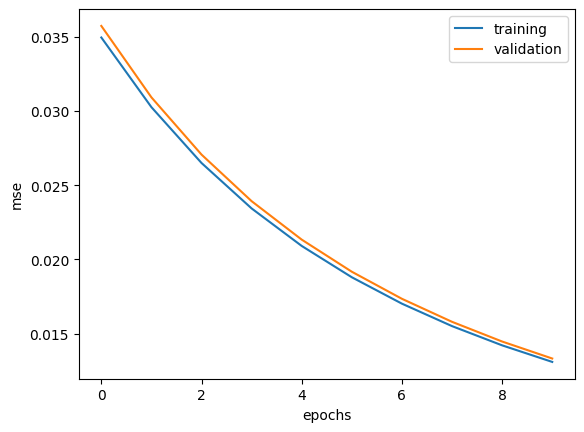

In [12]:
step = 1

plt.plot(instance.losses[::step], label="training")
plt.plot(instance.val_losses[::step],label="validation")
plt.ylabel("mse")
plt.xlabel("epochs")
# plt.yscale("log")
plt.legend()

In [13]:
description = ""

In [14]:
toSave = newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [28]:
save_path = "./../models/correctors/laplacian_correctors/first_laplacians.pickle"

In [16]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [29]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [30]:
loaded.description

'57 min CPU time, learning_rates = ((120,0.01),(30,0.001)), 150 epochs'

## Evaluating the model 

In [31]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [32]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

In [33]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [34]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [35]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(npLaplacian(X_test[j]))

In [36]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [37]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(Y_test))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(Y_test))))

Test error for NN
	Error : 0.042474
	Error/mean(||truth||) : 1.699393

Error if no NN used
	Error : 0.242677
	Error/mean(||truth||) : 9.709582
